# Modelo de deterioro de cuentas por cobrar de acuerdo con la NIIF 9

## Cargue de los datos

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Agrega la ruta del directorio 'src' al path

sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np

#Librerias Machine Learning y modelado
from pycaret.classification import *
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

#Librerias para visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from procesamiento_datos import *

Función de procesamiento de datos cargadas correctamente.


In [2]:
# cargar los dataset 

ruta_base = os.path.abspath(os.path.join(os.getcwd(), '..'))

df_cierres = pd.read_csv(ruta_base+"/data/raw/Historico_Cierres_Tipo.csv")
df_variables_macro = pd.read_csv(ruta_base+"/data/raw/Variables_Macro.csv")
df_score = pd.read_csv(ruta_base+"/data/processed/datos_modelado.csv")

In [3]:
df_cierres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13079 entries, 0 to 13078
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha_cierre          13079 non-null  object 
 1   NIT                   13079 non-null  object 
 2   Fecha_vencimiento     13079 non-null  object 
 3   Dias_mora             13079 non-null  int64  
 4   Calificación          13079 non-null  object 
 5   Saldo                 13079 non-null  float64
 6   Porcentaje_deterioro  13079 non-null  float64
 7   Deterioro             13079 non-null  float64
 8   FID                   13079 non-null  object 
 9   nombre_linea          13079 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 1021.9+ KB


In [4]:
convertir_fecha(df_cierres,['Fecha_vencimiento','fecha_cierre'])
df_cierres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13079 entries, 0 to 13078
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fecha_cierre          13079 non-null  datetime64[ns]
 1   NIT                   13079 non-null  object        
 2   Fecha_vencimiento     13079 non-null  datetime64[ns]
 3   Dias_mora             13079 non-null  int64         
 4   Calificación          13079 non-null  object        
 5   Saldo                 13079 non-null  float64       
 6   Porcentaje_deterioro  13079 non-null  float64       
 7   Deterioro             13079 non-null  float64       
 8   FID                   13079 non-null  object        
 9   nombre_linea          13079 non-null  object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 1021.9+ KB


In [5]:
df_variables_macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fecha_cierre      906 non-null    object 
 1   smmlv             498 non-null    float64
 2   ipc               318 non-null    float64
 3   pib               246 non-null    float64
 4   tasa              328 non-null    float64
 5   var_pct_ipc_1m    906 non-null    float64
 6   var_pct_pib_1m    906 non-null    float64
 7   var_pct_tasa_1m   906 non-null    float64
 8   var_pct_smmlv_1m  906 non-null    float64
dtypes: float64(8), object(1)
memory usage: 63.8+ KB


In [6]:
convertir_fecha(df_variables_macro,['fecha_cierre'])
df_variables_macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_cierre      906 non-null    datetime64[ns]
 1   smmlv             498 non-null    float64       
 2   ipc               318 non-null    float64       
 3   pib               246 non-null    float64       
 4   tasa              328 non-null    float64       
 5   var_pct_ipc_1m    906 non-null    float64       
 6   var_pct_pib_1m    906 non-null    float64       
 7   var_pct_tasa_1m   906 non-null    float64       
 8   var_pct_smmlv_1m  906 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 63.8 KB


In [7]:

df_cierres_agg = df_cierres.merge(df_variables_macro, on= 'fecha_cierre', how='left')
df_cierres_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13079 entries, 0 to 13078
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fecha_cierre          13079 non-null  datetime64[ns]
 1   NIT                   13079 non-null  object        
 2   Fecha_vencimiento     13079 non-null  datetime64[ns]
 3   Dias_mora             13079 non-null  int64         
 4   Calificación          13079 non-null  object        
 5   Saldo                 13079 non-null  float64       
 6   Porcentaje_deterioro  13079 non-null  float64       
 7   Deterioro             13079 non-null  float64       
 8   FID                   13079 non-null  object        
 9   nombre_linea          13079 non-null  object        
 10  smmlv                 13079 non-null  float64       
 11  ipc                   13079 non-null  float64       
 12  pib                   13079 non-null  float64       
 13  tasa            

In [8]:
df_clientes = pd.read_csv(ruta_base+'/data/raw/Informacion_Clientes.csv')
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697 entries, 0 to 2696
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NIT                        2697 non-null   object 
 1   PERIODO                    2697 non-null   object 
 2   FECHA_CORTE                2697 non-null   object 
 3   ACTIVOS_CORRIENTES         2697 non-null   float64
 4   GANANCIAS                  2697 non-null   float64
 5   PATRIMONIO                 2697 non-null   float64
 6   TOTAL_ACTIVOS              2697 non-null   float64
 7   ACTIVOS_NO_CORRIENTES      2697 non-null   float64
 8   PASIVOS_NO_CORRIENTES      2697 non-null   float64
 9   TOTAL_PASIVOS              2697 non-null   float64
 10  VAR_ACTIVOS_CORRIENTES     2697 non-null   float64
 11  VAR_GANANCIAS              2696 non-null   float64
 12  VAR_PATRIMONIO             2697 non-null   float64
 13  VAR_ACTIVOS                2697 non-null   float

In [9]:
df_cierres_cliente = df_cierres_agg.copy()

In [10]:
df_cierres_cliente = df_cierres_cliente.merge(df_clientes,on='NIT',how='left')
df_cierres_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13079 entries, 0 to 13078
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha_cierre               13079 non-null  datetime64[ns]
 1   NIT                        13079 non-null  object        
 2   Fecha_vencimiento          13079 non-null  datetime64[ns]
 3   Dias_mora                  13079 non-null  int64         
 4   Calificación               13079 non-null  object        
 5   Saldo                      13079 non-null  float64       
 6   Porcentaje_deterioro       13079 non-null  float64       
 7   Deterioro                  13079 non-null  float64       
 8   FID                        13079 non-null  object        
 9   nombre_linea               13079 non-null  object        
 10  smmlv                      13079 non-null  float64       
 11  ipc                        13079 non-null  float64       
 12  pib 

In [11]:
df_cierres_cliente = df_cierres_cliente.merge(df_score[['NIT','score_credito']],on='NIT', how='left')
df_cierres_cliente.head()

,fecha_cierre,NIT,Fecha_vencimiento,Dias_mora,Calificación,Saldo,Porcentaje_deterioro,Deterioro,FID,nombre_linea,...,VAR_PASIVOS_NO_CORRIENTES,VAR_TOTAL_PASIVOS,PASIVOS_CORRIENTES,VAR_PASIVOS_CORRIENTES,UTILIDAD_NETA,LIQUIDEZ_CORRIENTE,CAPITAL_TRABAJO,ENDEUDAMIENTO,ROA,score_credito
0,2023-01-31,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,2022-09-15,0,A,2380000.0,0.0022,5236.0,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,Inmobiliario,...,528.398825,-9.654030,6997878.0,-87.263588,2728080.0,7.13,42878314.0,1.00,4.81,100.0
1,2023-01-31,a6f8bc5c429a36aba24d818a811da81ef5f66107c131f4...,2023-02-28,0,A,0.0,0.0022,0.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,Otros,...,-19.458861,-31.443608,1228610.0,-77.468232,-423509.0,1.51,624676.0,1.17,-2.73,84.0
2,2023-01-31,f810167a3f88559f1cf90ac412c7d70c0de7f54742bcad...,2023-02-28,0,A,0.0,0.0022,0.0,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,Administración,...,248.973746,67.151176,7223354.0,-39.709844,-2653178.0,2.93,13976680.0,0.76,-6.34,78.9
3,2023-01-31,c8ad84d88132c613b3343688e13ada573e8976d18b58ec...,2023-02-28,0,A,0.0,0.0022,0.0,aa6df8861c8ad85418960d463c1bfff2ec9d257d58e5ab...,Fondos de inversión colectiva,...,inf,366.503959,2880835.0,125.100582,-422714.0,3.22,6396260.0,0.64,-4.50,91.4
4,2023-01-31,c5cd27ae8413be0c194958c8ad37774a81b07873ab2642...,2023-02-28,0,A,0.0,0.0022,0.0,f4b94821159e4974022084b6d3735e1ff440cab7d97ce5...,Inmobiliario,...,121.365063,121.365063,0.0,NaN,-26634.0,inf,3888635.0,0.67,-0.20,99.7


In [12]:
df_cierres_cliente['default'] = df_cierres_cliente.apply(lambda row : 1 if row['Dias_mora'] > 90 or row['score_credito'] < 30 else 0, axis=1 )
print(df_cierres_cliente['default'].value_counts())

default
0    11133
1     1946
Name: count, dtype: int64


## Modelamiento

In [13]:
import pandas as pd
import numpy as np

#Librerias Machine Learning y modelado
from pycaret.classification import *
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

#Librerias para visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [20]:
df_modelo = df_cierres_cliente.copy()
crear_bines(df_modelo,'Saldo',numero_bines=5, metodo='uniform')

Columnas binarias creadas exitosamente para 'Saldo' usando método 'uniform'.
Distribución de bines:
Saldo
(-2501957.804, 500391560.8]     13046
(500391560.8, 1000783121.6]         7
(1000783121.6, 1501174682.4]       25
(1501174682.4, 2001566243.2]        0
(2001566243.2, 2501957804.0]        1
Name: count, dtype: int64


,fecha_cierre,NIT,Fecha_vencimiento,Dias_mora,Calificación,Saldo,Porcentaje_deterioro,Deterioro,FID,nombre_linea,...,CAPITAL_TRABAJO,ENDEUDAMIENTO,ROA,score_credito,default,"Saldo_bin_(-2501957.804, 500391560.8]","Saldo_bin_(500391560.8, 1000783121.6]","Saldo_bin_(1000783121.6, 1501174682.4]","Saldo_bin_(1501174682.4, 2001566243.2]","Saldo_bin_(2001566243.2, 2501957804.0]"
0,2023-01-31,bda703a41ee55dcb911f17164009bc87636552bd5a641b...,2022-09-15,0,A,2380000.00,0.0022,5236.00,b527ab75d12cba5a48db8e39b6dc776fafe8d0a64454c1...,Inmobiliario,...,42878314.0,1.00,4.81,100.0,0,1,0,0,0,0
1,2023-01-31,a6f8bc5c429a36aba24d818a811da81ef5f66107c131f4...,2023-02-28,0,A,0.00,0.0022,0.00,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,Otros,...,624676.0,1.17,-2.73,84.0,0,1,0,0,0,0
2,2023-01-31,f810167a3f88559f1cf90ac412c7d70c0de7f54742bcad...,2023-02-28,0,A,0.00,0.0022,0.00,eaab7f29f0ebeeb28a5fcae7dba2f7b07bf2fa942bab4b...,Administración,...,13976680.0,0.76,-6.34,78.9,0,1,0,0,0,0
3,2023-01-31,c8ad84d88132c613b3343688e13ada573e8976d18b58ec...,2023-02-28,0,A,0.00,0.0022,0.00,aa6df8861c8ad85418960d463c1bfff2ec9d257d58e5ab...,Fondos de inversión colectiva,...,6396260.0,0.64,-4.50,91.4,0,1,0,0,0,0
4,2023-01-31,c5cd27ae8413be0c194958c8ad37774a81b07873ab2642...,2023-02-28,0,A,0.00,0.0022,0.00,f4b94821159e4974022084b6d3735e1ff440cab7d97ce5...,Inmobiliario,...,3888635.0,0.67,-0.20,99.7,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13074,2025-06-30,93c7e29096be6b295b082af5134f6d6ccb70a4f5bd8186...,2023-12-17,561,E,36421600.00,1.0000,36421600.00,79c34e61bb9da63b9bb88d87c02a531d8af9ed16d85c22...,Inmobiliario,...,730332.0,0.53,0.71,36.8,1,1,0,0,0,0
13075,2025-06-30,56b6928bdc3879ed19779d840c562e5406d9b29d2cca32...,2024-03-21,466,E,49906220.00,1.0000,49906220.00,136a27f6f0fd70909720b12ee3519e5aaedfbbfbbce1da...,Garantía,...,30675881.0,0.16,14.57,27.3,1,1,0,0,0,0
13076,2025-06-30,f495b5a0005d360b2a2c3e358b2d7973c0b3e7a76e371d...,2022-11-11,962,E,13042400.00,1.0000,13042400.00,8005c981fac40b3ab78dc2d9271bed69f4f8b9d1e18686...,Garantía,...,-62488825.0,0.95,-9.17,60.7,1,1,0,0,0,0
13077,2025-06-30,fbbabd04e6dd67e5db8b9bb554145338c77d7415d5f620...,2020-11-14,1689,E,2383943.36,1.0000,2383943.36,9ac073a07be208df6fa2ee0e4ce2a1e66c3e7156772228...,Inmobiliario,...,2457761.0,0.19,1.49,31.4,1,1,0,0,0,0


In [21]:
X = df_modelo.drop(columns = ['default','Saldo','NIT','fecha_cierre','Deterioro','Fecha_vencimiento','Dias_mora','Calificación','FID','FECHA_CORTE','PERIODO','score_credito','Porcentaje_deterioro'])
y = df_modelo['default'] 

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

train_data = pd.concat([train_X, train_y], axis=1)
test_data = pd.concat([test_X, test_y], axis=1)

In [23]:
train_data_replaced = train_data.replace([np.inf, -np.inf], np.nan)
test_data_replaced = test_data.replace([np.inf, -np.inf], np.nan)

In [24]:
clf = setup(
    data=train_data_replaced,
    target='default',
    session_id=123,
    normalize=True,
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    fold=5,
    categorical_features=['nombre_linea'],
    verbose=True,
    remove_multicollinearity=True
    )

,Description,Value
0,Session id,123
1,Target,default
2,Target type,Binary
3,Original data shape,"(10463, 36)"
4,Transformed data shape,"(15607, 33)"
5,Transformed train set shape,"(12468, 33)"
6,Transformed test set shape,"(3139, 33)"
7,Numeric features,34
8,Categorical features,1
9,Rows with missing values,18.4%


In [25]:
best_model = compare_models(include=['xgboost','dt','lr','rf'],fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9597,0.9632,0.8578,0.8704,0.8636,0.8399,0.8403,1.4460
xgboost,Extreme Gradient Boosting,0.9555,0.9631,0.8073,0.8837,0.8436,0.8177,0.8190,2.3240
dt,Decision Tree Classifier,0.9362,0.8867,0.8037,0.7758,0.7894,0.7518,0.7521,0.4960
lr,Logistic Regression,0.5960,0.7044,0.6881,0.2227,0.3365,0.1440,0.1914,0.3120


In [26]:
tuned_best_model = tune_model(best_model, fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8655,0.9096,0.8257,0.5310,0.6463,0.5681,0.5892
1,0.8669,0.8860,0.7661,0.5370,0.6314,0.5532,0.5662
2,0.8730,0.9105,0.8073,0.5500,0.6543,0.5799,0.5959
3,0.8730,0.9033,0.8119,0.5497,0.6556,0.5812,0.5979
4,0.8907,0.9189,0.8257,0.5960,0.6923,0.6280,0.6403
Mean,0.8738,0.9056,0.8073,0.5527,0.6560,0.5821,0.5979
Std,0.0090,0.0110,0.0219,0.0229,0.0201,0.0251,0.0240


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
predict_model (tuned_best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9656,0.9614,0.8565,0.9070,0.8811,0.8610,0.8614


,nombre_linea,smmlv,ipc,pib,tasa,var_pct_ipc_1m,var_pct_pib_1m,var_pct_tasa_1m,var_pct_smmlv_1m,ACTIVOS_CORRIENTES,...,ENDEUDAMIENTO,ROA,"Saldo_bin_(-2501957.804, 500391560.8]","Saldo_bin_(500391560.8, 1000783121.6]","Saldo_bin_(1000783121.6, 1501174682.4]","Saldo_bin_(1501174682.4, 2001566243.2]","Saldo_bin_(2001566243.2, 2501957804.0]",default,prediction_label,prediction_score
10764,Inmobiliario,1423500.0,5.49,452132.03125,19.650000,0.733945,1.464090,0.357508,9.500000,331777.0,...,0.11,-0.320000,1,0,0,0,0,0,0,1.00
9431,Inmobiliario,1300000.0,5.91,445607.90625,20.299999,-4.368932,3.683884,-3.010033,12.068966,137361104.0,...,0.77,-0.240000,1,0,0,0,0,0,0,1.00
310,Administración,1160000.0,11.84,394716.62500,30.840000,2.510823,3.754114,7.419018,16.000000,148471152.0,...,0.37,-1.240000,1,0,0,0,0,0,0,0.97
12781,Inmobiliario,1423500.0,5.12,453675.56250,19.059999,-2.476191,0.341389,-1.192328,9.500000,331777.0,...,0.11,-0.320000,1,0,0,0,0,0,0,1.00
5082,Administración,1160000.0,9.46,400311.96875,26.080000,-3.861789,1.062036,-0.381971,16.000000,2417195.0,...,0.00,-1.080000,1,0,0,0,0,0,0,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,Inmobiliario,1160000.0,12.16,394716.62500,29.950001,2.702703,3.754114,-2.885863,16.000000,708035.0,...,0.04,5.440000,1,0,0,0,0,0,0,0.99
575,Inversión,1160000.0,12.16,394716.62500,29.950001,2.702703,3.754114,-2.885863,16.000000,141403200.0,...,0.59,3.960000,1,0,0,0,0,0,0,1.00
3571,Inmobiliario,1160000.0,10.85,396105.18750,26.360001,-3.726708,0.680421,-4.630970,16.000000,36752936.0,...,0.50,0.430000,1,0,0,0,0,0,0,1.00
7164,Inmobiliario,1300000.0,7.17,421222.62500,22.250000,-2.182810,2.777054,-3.762976,12.068966,377778816.0,...,0.82,0.050000,1,0,0,0,0,0,0,0.99


In [28]:
evaluate_model(tuned_best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Calculo de la PD

In [34]:
# Calcular la Probabilidad de Incumplimiento (PD) usando el modelo ajustado de PyCaret
test_pred = predict_model(tuned_best_model, data=test_X)
# La columna 'Score' contiene la PD para cada registro
test_X['PD'] = test_pred['Score']
# Visualizar las primeras probabilidades calculadas
test_X[['PD']].head()

ValueError: Input X contains infinity or a value too large for dtype('float64').

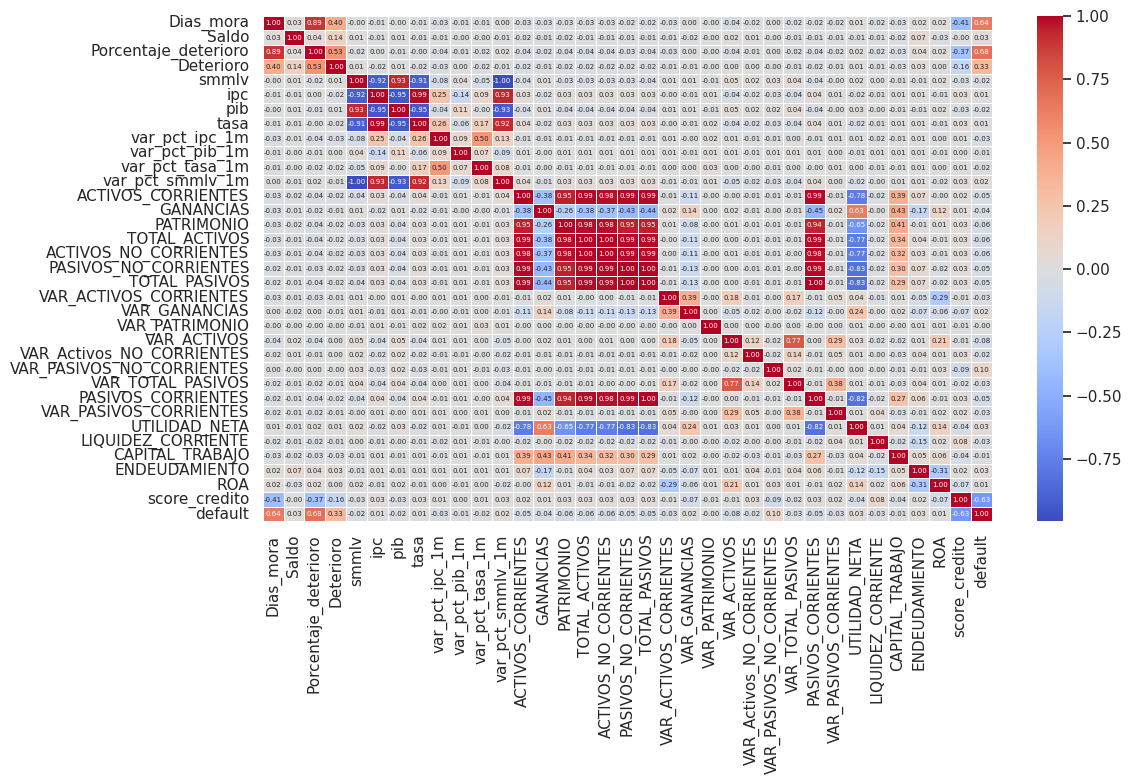

In [29]:
'''correlacion = df_cierres_cliente.select_dtypes(include='number')

plt.figure(figsize=(12,8))
sns.heatmap(correlacion.corr(), annot=True,fmt='.2f',cmap='coolwarm',center=0,linewidths=0.5, annot_kws={"size":5})
plt.tight_layout()
plt.show()'''

# --- Stage ---

In [30]:
# STAGE

'''df_cierres_cliente['Etapa_actual'] = df_cierres_cliente['Dias_mora'].apply(lambda x: 1 if x <= 90 else (2 if x <= 360 else 3 ))
df_cierres_cliente['Etapa_NIIF'] = df_cierres_cliente['Dias_mora'].apply(lambda x: 1 if x == 0 else (2 if x <= 90 else 3 ))'''

In [31]:
'''etapa_actual = df_cierres_cliente.groupby(['Etapa_actual']).agg(cantidad = ('Etapa_actual','count'), saldo = ('Saldo','sum'), deterioro =('Deterioro','sum')).reset_index()
print (etapa_actual)'''

   Etapa_actual  cantidad         saldo     deterioro
0             1     11512  1.130505e+11  2.700405e+08
1             2      1242  1.941939e+10  5.126742e+09
2             3       325  6.995796e+09  6.995796e+09


In [32]:
'''etapa_NIIF = df_cierres_cliente.groupby(['Etapa_NIIF']).agg(cantidad = ('Etapa_NIIF','count'), saldo = ('Saldo','sum'),deterioro =('Deterioro','sum')).reset_index()
print (etapa_NIIF)'''

   Etapa_NIIF  cantidad         saldo     deterioro
0           1      8433  8.620164e+10  1.896436e+08
1           2      3079  2.684888e+10  8.039689e+07
2           3      1567  2.641518e+10  1.212254e+10


In [33]:
'''diferencias = etapa_actual.merge(etapa_NIIF, left_on='Etapa_actual', right_on='Etapa_NIIF', how='left')
diferencias['Diferencia_cant'] = diferencias['cantidad_x']-diferencias['cantidad_y']
diferencias['Diferencia_saldo'] = diferencias['saldo_x']-diferencias['saldo_y']
diferencias['Diferencia_deterioro'] = diferencias['deterioro_x']-diferencias['deterioro_y']
diferencias['porc_deteriorado_x'] = diferencias['deterioro_x']/diferencias['saldo_x']
diferencias['porc_deteriorado_y'] = diferencias['deterioro_y']/diferencias['saldo_y']
print(diferencias)'''

   Etapa_actual  cantidad_x       saldo_x   deterioro_x  Etapa_NIIF  \
0             1       11512  1.130505e+11  2.700405e+08           1   
1             2        1242  1.941939e+10  5.126742e+09           2   
2             3         325  6.995796e+09  6.995796e+09           3   

   cantidad_y       saldo_y   deterioro_y  Diferencia_cant  Diferencia_saldo  \
0        8433  8.620164e+10  1.896436e+08             3079      2.684888e+10   
1        3079  2.684888e+10  8.039689e+07            -1837     -7.429494e+09   
2        1567  2.641518e+10  1.212254e+10            -1242     -1.941939e+10   

   Diferencia_deterioro  porc_deteriorado_x  porc_deteriorado_y  
0          8.039689e+07            0.002389            0.002200  
1          5.046345e+09            0.264001            0.002994  
2         -5.126742e+09            1.000000            0.458923  
